In [ ]:
import plotly.graph_objects as go
import numpy as np
import sympy as sp
import numpy.linalg as LA
import numpy.random as npr
from scipy.special import binom
import scipy.interpolate as sin
from scipy import stats

In [ ]:
#Import libraries

import numpy as np
import math as math
import cmath as cmath
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import partial

#Class to hold the relevant functions

class Heston(object):

    def __init__(self,S0,K,tau,r,kappa,theta,v0,lamda,sigma,rho): #Constructor for initiating the class

        self.x0=math.log(S0);
        self.ln_k=math.log(K);
        self.r=r;
        self.v0=v0;
        self.kappa=kappa;
        self.theta=theta;
        self.lamda=lamda;
        self.sigma=sigma;
        self.rho=rho;
        self.tau=tau;

        self.a=kappa*theta;
        self.u=[0.5,-0.5];
        self.b=[kappa+lamda-rho*sigma,kappa+lamda];

    def reset_parameters(self,S0,K,tau,r,kappa,theta,v0,lamda,sigma,rho): # Function for resetting the constant parameters
        self.x0=math.log(S0);
        self.ln_k=math.log(K);
        self.r=r;
        self.v0=v0;
        self.kappa=kappa;
        self.theta=theta;
        self.lamda=lamda;
        self.sigma=sigma;
        self.rho=rho;
        self.tau=tau;

        self.a=kappa*theta;
        self.u=[0.5,-0.5];
        self.b=[kappa+lamda-rho*sigma,kappa+lamda];


    def characteristic_func(self,phi):#Return the characteristic functions f1 and f2, each of which has a real and a complex part

        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        for j in range(2):

            temp=self.b[j]-1j*self.rho*self.sigma*phi;

            d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));

            g[j]=(temp+d[j])/(temp-d[j]);

            edt[j]=cmath.exp(d[j]*self.tau);
            gedt[j]=1.0-g[j]*edt[j];

            D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
            C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
            f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);

        return f;

    def f1(self,phi):#f1 only using a copy of the previous code with minimal change, i.e.,j=0 replaes loop

        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        j=0;

        temp=self.b[j]-1j*self.rho*self.sigma*phi;

        d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));
        g[j]=(temp+d[j])/(temp-d[j]);

        edt[j]=cmath.exp(d[j]*self.tau);
        gedt[j]=1.0-g[j]*edt[j];

        D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
        C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
        f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);

        return f[0];

    def f2(self,phi):# f2 only using a copy of the previous code with minimal change, i.e.,now j=1 replaes loop

        d=[0.0,0.0];g=[0.0,0.0];C=[0.0,0.0];D=[0.0,0.0];edt=[0.0,0.0];gedt=[0.0,0.0]; f=[0.0,0.0];

        j=1;

        temp=self.b[j]-1j*self.rho*self.sigma*phi;

        d[j]=cmath.sqrt(temp**2-self.sigma**2*(2.0*self.u[j]*phi*1j-phi**2));
        g[j]=(temp+d[j])/(temp-d[j]);

        edt[j]=cmath.exp(d[j]*self.tau);
        gedt[j]=1.0-g[j]*edt[j];

        D[j]=(temp+d[j])*(1.0-edt[j])/gedt[j]/self.sigma/self.sigma;
        C[j]=self.r*phi*self.tau*1j+self.a/self.sigma/self.sigma*((temp+d[j])*self.tau-2.0*cmath.log(gedt[j]/(1.0-g[j])));
        f[j]=cmath.exp(C[j]+D[j]*self.v0+1j*phi*self.x0);

        return f[1];

    def P1_integrand(self,phi): #Returns the integrand  that appears in the P1 formula
        temp=cmath.exp(-1j*phi*self.ln_k)*self.f1(phi)/1j/phi;
        return temp.real;

    def P2_integrand(self,phi):  #Returns the integrand  that appears in the P1 formula
        temp=cmath.exp(-1j*phi*self.ln_k)*self.f2(phi)/1j/phi;
        return temp.real;

    def Probabilities(self,a,b,n):  #Compute the two probabilities: a and b are the integration limits, n is the number of intervals
                                    # usually the interval >0 to 100 captures the range that matters, so no need to go to b=infinity!
        pi_i=1.0/math.pi;
        P1=0.5+pi_i*trapzd(self.P1_integrand,a,b,n); #trapzd function is de
        P2=0.5+pi_i*trapzd(self.P2_integrand,a,b,n);
        P=[P1,P2];
        return P;

    def price(self,a,b,n):
        Ps=self.Probabilities(a,b,n);

        call_price=math.exp(self.x0)*Ps[0]-math.exp(self.ln_k-self.r*self.tau)*Ps[1];
        put_price=call_price-(math.exp(self.x0)-math.exp(self.ln_k-self.r*self.tau));

        output={
            "Call price":call_price,
            "Put price":put_price,
            "P1":Ps[0],
            "P2":Ps[1]
        }
        return output;

    def plot_f1f2(self): # Plot real parts of the characteristic functions (f1 and f2),
                         # and the integrands that appear in P1 and P2

        n=2000;
        lwr=-50.111;
        upr=50.0311;

        x=np.linspace(lwr,upr,n+1);
        fs=[self.characteristic_func(x[i]) for i in range(n+1)];

        y1=[fs[i][0].real for i in range(n+1)];
        y2=[fs[i][0].imag for i in range(n+1)];
        y3=[self.P1_integrand(x[i]) for i in range(n+1)];
        y4=[fs[i][1].real for i in range(n+1)];
        y5=[fs[i][1].imag for i in range(n+1)];
        y6=[self.P2_integrand(x[i]) for i in range(n+1)];

        fig=plt.figure();
        f1_real=fig.add_subplot(231);
        f1_real.set_title('Real part of F1');
        f1_real.plot(x,y1);

        f1_imag=fig.add_subplot(232);
        f1_imag.set_title('Imaginary part of F1');
        f1_imag.plot(x,y2);

        f1_integrand=fig.add_subplot(233);
        f1_integrand.set_title('Integrand of P1');
        f1_integrand.plot(x,y3);

        f2_real=fig.add_subplot(234);
        f2_real.set_title('Real part of F2');
        f2_real.plot(x,y4);

        f2_imag=fig.add_subplot(235);
        f2_imag.set_title('Imaginary part of F2');
        f2_imag.plot(x,y5);

        f2_integrand=fig.add_subplot(236);
        f2_integrand.set_title('Integrand of P2');
        f2_integrand.plot(x,y6);

        plt.show();

  #end class


def trapzd(func,a,b,n): #Trapzoid method for numerical integration, one can also use a function from scipy.integrate library

    if (n<1):
        return ;
    elif (n==1):
        return 0.5*(b-a)*(func(a)+func(b));
    else:

        temp=0.0;
        dx=(b-a)/n;

        x=np.linspace(a,b,n+1);
        y=[func(x[i]) for i in range(n+1)];

        temp=0.5*dx*np.sum(y[1:]+ y[:-1]);
        return temp;


#Usage Example
#hc=Heston(S0=240,K=235,tau=1/12,r=0.027,kappa=5.0,theta=0.1,v0=0.4269,lamda=0.5,sigma=0.4269,rho=-0.7);

#price=hc.price(0.00001,100,10000);

#print("The prices of European options and the underlying P1 and P2 are presented below:\n")
#print(price)

#print("\n\nThe price is based on the following parameters:\n")
#print(vars(hc))
#hc.plot_f1f2()

options_data = [
    {'S0': 20.91, 'K': 21, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 2.01},
    {'S0': 20.91, 'K': 20, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 2.77},
    {'S0': 20.91, 'K': 17, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 5.5},
    {'S0': 20.91, 'K': 11, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 11.41},
    {'S0': 20.91, 'K': 14, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 8.43},
    {'S0': 20.91, 'K': 19, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 3.63},
    {'S0': 20.91, 'K': 16, 'tau': 3/252, 'r': 0.0465*3/252, 'v0': 0.72, 'market_price': 6.47}
]

# Function to calculate the squared difference between model price and market price
def objective_function(params, option_data):
    kappa, theta, sigma, lamda, rho = params
    model_prices = []

    for option in option_data:
        hc = Heston(option['S0'], option['K'], option['tau'], option['r'], kappa, theta, option['v0'], lamda,sigma, rho)
        model_prices.append(hc.price(0.00001, 100, 10000)['Call price'])  # Using call price for optimization

    return np.sum((np.array(model_prices) - np.array([option['market_price'] for option in option_data]))**2)

# Initial guess for the parameters
initial_params = [5.0, 0.1, 0.4269, 0.5, -0.7]

# Perform optimization
result = minimize(partial(objective_function, option_data=options_data), initial_params, method='Nelder-Mead')

# Extract optimized parameters
optimized_params = result.x

print("Optimized Parameters:")
print("kappa:", optimized_params[0])
print("theta:", optimized_params[1])
print("sigma:", optimized_params[2])
print("lamda:", optimized_params[3])
print("rho:", optimized_params[4])

Optimized Parameters:
kappa: -74.95699093924736
theta: 0.5196561116141674
sigma: 1.6517242175941487
lamda: -9.881809511754781
rho: -1.617885879471375


The prices of European options and the underlying P1 and P2 are presented below:

{'Call price': 6.591084326598226, 'Put price': 0.6809854748831263, 'P1': 1.0575532265357663, 'P2': 1.0348303956682732}


The price is based on the following parameters:

{'x0': 3.0402275134405423, 'ln_k': 2.70805020110221, 'r': 0.0005535714285714287, 'v0': 0.72, 'kappa': -74.95699093924736, 'theta': 0.5196561116141674, 'lamda': -9.881809511754781, 'sigma': 1.6517242175941487, 'rho': -1.617885879471375, 'tau': 0.011904761904761904, 'a': -38.95185844978766, 'u': [0.5, -0.5], 'b': [-82.16649916257566, -84.83880045100214]}


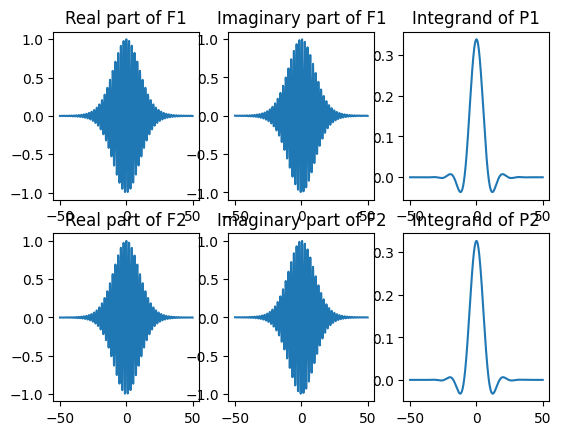

In [ ]:
#Usage Example
hc=Heston(S0=20.91,K=15,tau=3/252,r=00.0465*3/252,kappa=-74.95699093924736,theta=0.5196561116141674,v0=0.72,lamda=-9.881809511754781,sigma=1.6517242175941487,rho=-1.617885879471375);

price=hc.price(0.00001,100,10000);

print("The prices of European options and the underlying P1 and P2 are presented below:\n")
print(price)

print("\n\nThe price is based on the following parameters:\n")
print(vars(hc))
hc.plot_f1f2()

In [ ]:
def bs_no_Div(s0, X, sigma, r, T,call=True):
    """Calculate price of an option with BS equation for option pricing:
    - s0: price today of underlying asset
    - X: strike price
    - r: annualized risk-free rate
    - T: time to maturity expressed yearly
    - call: optional boolen parameter, if True option in question is call, else it is treated as put"""
    d1 = (np.log(s0/X) + (r + sigma**2/ 2)*T)/(sigma * np.sqrt(T))
    d2 = (np.log(s0/X) + (r - sigma**2/ 2)*T)/(sigma * np.sqrt(T))
    if call:
        return s0*stats.norm.cdf(d1) - X*np.exp(-r*T)*stats.norm.cdf(d2)
    else:
        return X*np.exp(-r*T)*stats.norm.cdf(-d2) - s0*stats.norm.cdf(-d1)

In [ ]:
bs_price=bs_no_Div(20.91,15,0.72,0.0465*3/252,3/252,call=True)
bs_price

5.9101023742302825

In [ ]:
true_price= 7.44
print(true_price-bs_price)
print(true_price-6.591084326598226)

1.5298976257697179
0.8489156734017742


In [ ]:
import math

def calculate_option_price(S, K, r, T, N, option_type='call'):
    """
    Calculate option price using the Cox-Ross-Rubinstein (CRR) model.

    Parameters:
    S (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate per period
    T (float): Time to expiration in years
    N (int): Number of time periods (steps in the binomial tree)
    option_type (str): Type of option, 'call' for call option and 'put' for put option

    Returns:
    float: Option price
    """

    dt = T / N  # Time step
    u = math.exp(r * dt)  # Up factor
    d = 1 / u  # Down factor
    p = (math.exp(r * dt) - d) / (u - d)  # Probability of up move

    # Initialize option values at maturity
    option_values = [0] * (N + 1)
    for i in range(N + 1):
        if option_type == 'call':
            option_values[i] = max(0, S * (u ** i) * (d ** (N - i)) - K)
        elif option_type == 'put':
            option_values[i] = max(0, K - S * (u ** i) * (d ** (N - i)))

    # Calculate option price at each node of the tree
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            option_values[i] = math.exp(-r * dt) * (p * option_values[i + 1] + (1 - p) * option_values[i])

    return option_values[0]

# Example usage:
S0 = 20.91  # Current stock price
K = 15   # Strike price
r = 0.0465*3/252  # Risk-free interest rate
T = 3/252     # Time to expiration in years
N = 100   # Number of time periods

call_option_price = calculate_option_price(S0, K, r, T, N, option_type='call')
put_option_price = calculate_option_price(S0, K, r, T, N, option_type='put')

print(f'Call Option Price: {call_option_price:.2f}')
print(f'Put Option Price: {put_option_price:.2f}')

Call Option Price: 5.91
Put Option Price: 0.00
